In [1]:
# This block is from https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import seaborn as sns #collection of functions for data visualization
print("seaborn version: {}". format(sns.__version__))

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder #OneHot Encoder

#misc libraries
import random
import time

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)


Python version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.0.1
matplotlib version: 3.1.3
NumPy version: 1.18.1
SciPy version: 1.4.1
IPython version: 7.12.0
scikit-learn version: 0.22.1
seaborn version: 0.10.0
-------------------------


## Load the files

In [2]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
sample_raw = pd.read_csv('data/sample_submission.csv')

In [3]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
def null_p (column):
    num_rows = train_raw.shape[0]
    null_percent = (column.isnull().sum() /num_rows)*100
    return null_percent

In [5]:
#drop columns with more than null_bar% of null data
def drop_null_col (df, null_bar):
    col_ls = []
    for col in df.columns:

        if null_p(df[col]) > null_bar:
            col_ls.append(col)
        
    return col_ls

In [6]:
#get a list of columns to drop
cols_drop = drop_null_col(train_raw, 40)

In [7]:
cols_drop

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [8]:
#generate a df with all the cols with 40% or more null data dropped
train_data_dnull = train_raw.copy().drop(cols_drop, axis = 1)

In [9]:
def null_p_df (df):
    p_ls = []
    type_ls = []
    for col in df.columns:
        n_percent = null_p(df[col])
        p_ls.append(n_percent)
        type_ls.append(df[col].dtype)
    np_df = pd.DataFrame({'Column Name': df.columns, "Null Percent": p_ls, "Data Type": type_ls})
    return np_df

In [10]:
np_df = null_p_df(train_data_dnull)

In [11]:
np_df.sort_values(by = 'Null Percent',  ascending=False).head(20)

,Column Name,Null Percent,Data Type
3,LotFrontage,17.739726,float64
56,GarageType,5.547945,object
62,GarageCond,5.547945,object
57,GarageYrBlt,5.547945,float64
58,GarageFinish,5.547945,object
61,GarageQual,5.547945,object
34,BsmtFinType2,2.602740,object
31,BsmtExposure,2.602740,object
32,BsmtFinType1,2.534247,object
30,BsmtCond,2.534247,object


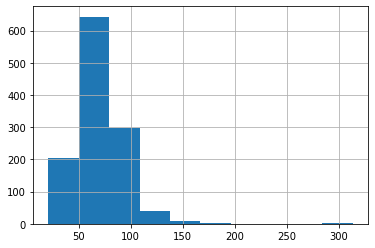

In [12]:
#need special attention on LotFrontage, let's take a look at the distribution 
train_data_dnull.LotFrontage.hist()

#### Observation
Fairly normal distributed, some outliers at 300

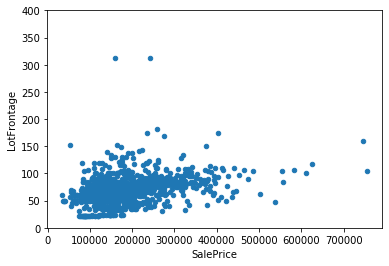

In [13]:
#let's look at how it relates to our target
train_data_dnull.plot.scatter(x='SalePrice', y='LotFrontage', ylim=(0,400));

#### Observation
Doesnt seem like there are any trend in relation to SalePrice

#### Action Plan
We can fillna with mean

In [14]:
np_df.sort_values(by = 'Null Percent',  ascending=False).head(20)

,Column Name,Null Percent,Data Type
3,LotFrontage,17.739726,float64
56,GarageType,5.547945,object
62,GarageCond,5.547945,object
57,GarageYrBlt,5.547945,float64
58,GarageFinish,5.547945,object
61,GarageQual,5.547945,object
34,BsmtFinType2,2.602740,object
31,BsmtExposure,2.602740,object
32,BsmtFinType1,2.534247,object
30,BsmtCond,2.534247,object


#### Observation
With the decision of handling LotFrontage na with mean, and the other null percentages are relatively small, we could process fillna for these columns in batches

#### Action Plan
We will handle columns with null values in batches

In [15]:
from sklearn.impute import SimpleImputer

def clear_na (df):
    
    #let split the data for more targeted handling
    txt_cols = [cname for cname in df.columns if df[cname].dtype == "object"]

    # Select numerical columns
    num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

    
    txt_imputer = sklearn.impute.SimpleImputer(strategy='most_frequent')
    num_imputer = sklearn.impute.SimpleImputer(strategy='mean')
    
    txt_nonull = pd.DataFrame(txt_imputer.fit_transform(df[txt_cols]))
    txt_nonull.columns = txt_cols
    num_nonull = pd.DataFrame(num_imputer.fit_transform(df[num_cols]))
    num_nonull.columns = num_cols
    
    clean_df = txt_nonull.join(num_nonull)
    
    return clean_df
    
    

In [16]:
train_clean = clear_na(train_data_dnull)

In [17]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   Street         1460 non-null   object 
 2   LotShape       1460 non-null   object 
 3   LandContour    1460 non-null   object 
 4   Utilities      1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   LandSlope      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   Condition2     1460 non-null   object 
 10  BldgType       1460 non-null   object 
 11  HouseStyle     1460 non-null   object 
 12  RoofStyle      1460 non-null   object 
 13  RoofMatl       1460 non-null   object 
 14  Exterior1st    1460 non-null   object 
 15  Exterior2nd    1460 non-null   object 
 16  MasVnrType     1460 non-null   object 
 17  ExterQual      1460 non-null   object 
 18  ExterCon

In [18]:
#okay, now we have a clean dataset, let's take a look at the data more closely to understand what types of data we are dealing with
#to do this, we will break the data to txt and num, to allow easier handling

def txt_num_split(df):

    #let split the data for more targeted handling
    txt_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    # Select numerical columns
    num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    
    txt_df = df[txt_cols]
    num_df = df[num_cols]
    
    return txt_df, num_df


In [19]:
train_clean_txt, train_clean_num = txt_num_split(train_clean)

In [20]:
train_clean_txt.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1335,735,1360,951,686,1392,1407,1340,1267,1198


In [21]:
uv_df = pd.DataFrame(train_clean_txt.describe().loc['unique'])

In [22]:
uv_df.sort_values(by = 'unique', ascending=False)

,unique
Neighborhood,25
Exterior2nd,16
Exterior1st,15
SaleType,9
Condition1,9
Condition2,8
HouseStyle,8
RoofMatl,8
Functional,7
Foundation,6


#### Observation
Neighborhood, Exterior2nd, Exterior1st have more than 10 unique values, cant use onehot

#### Action Plan
let's see if we could further group the valuse for the above mentioned

In [23]:
train_clean_txt.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

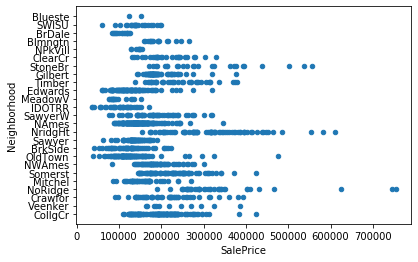

In [24]:
#let's look at how it relates to our target
train_clean.plot.scatter(x='SalePrice', y='Neighborhood')

#### Observation
there is no specific trends in this data, and after reading the description, we think that there might not be a good way to furter aggregate the data

#### Action Plan
use some sort of lable encoder, or combine with another cat data

In [25]:
import category_encoders as ce

# Create the encoder
target_enc = ce.CatBoostEncoder(cols=['Neighborhood'])
target_enc_fitted = target_enc.fit(train_clean_txt['Neighborhood'], train_clean['SalePrice'])
nbh_trans = target_enc_fitted.transform(train_clean_txt['Neighborhood'])


In [26]:
nbh_trans

,Neighborhood
0,197852.895337
1,233951.766324
2,197852.895337
3,210053.503767
4,331619.742759
...,...
1455,192705.339949
1456,188940.218863
1457,210053.503767
1458,146002.275203


In [27]:
train_clean.Exterior2nd.value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

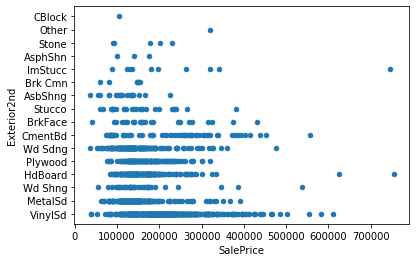

In [28]:
train_clean.plot.scatter(x='SalePrice', y='Exterior2nd')

#### Observation
CBlock, Other Stone, AsphShn, ImStucc, Brk Cmn are in similar ranges

#### Action Plan
let's combine them

In [29]:
combine_ls = ['CBlock', 'Other', 'Stone', 'AsphShn', 'ImStucc', 'Brk Cmn']
train_clean_txt.Exterior2nd = train_clean_txt.Exterior2nd.apply(lambda x: 'Other' if x in combine_ls else x)

In [30]:
train_clean_txt.Exterior2nd.value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Other       27
Stucco      26
BrkFace     25
AsbShng     20
Name: Exterior2nd, dtype: int64

In [31]:
train_clean_txt.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [32]:
combine_ls_e1 = ['CBlock', 'Other', 'Stone', 'AsphShn', 'ImStucc', 'BrkComm']
train_clean_txt.Exterior1st = train_clean_txt.Exterior1st.apply(lambda x: 'Other' if x in combine_ls_e1 else x)

In [33]:
train_clean_txt.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Other        7
Name: Exterior1st, dtype: int64

### Action Plan
We will apply onehot to cols with less than 10 unique values and target encoding for the ones with more than 10

# We look at num cols

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001744BB8B148>,
      dtype=object)

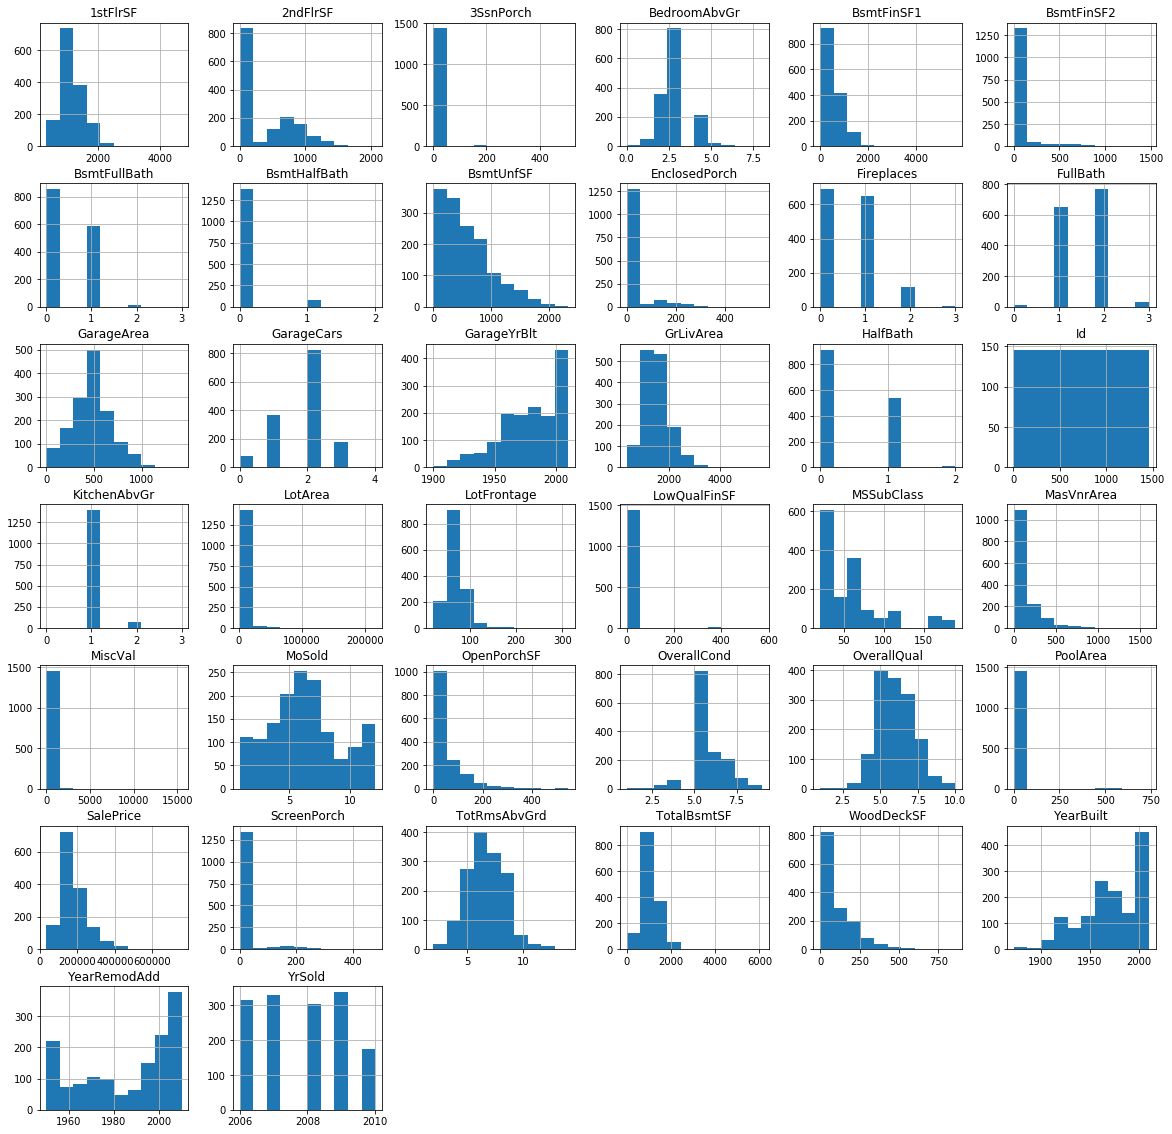

In [34]:
train_clean_num.hist(figsize = (20,20))

In [35]:
num_cat_cols = ['GarageYrBlt', 'MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']

In [36]:
def one_hot (raw_df, cat_cols):
    
    df = raw_df.copy()
    
    #next we apply One-Hot
    OH_en = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_source_df_imputed_col = OH_en.fit_transform(df[cat_cols])
    OH_source_df_imputed_col = pd.DataFrame(OH_source_df_imputed_col)
    
    #alining index 
    OH_source_df_imputed_col.index = df.index
    #alining columns
    OH_source_df_imputed_col.columns = OH_en.get_feature_names(cat_cols)
    return OH_source_df_imputed_col

In [37]:
onehot_test = one_hot(train_clean_num, num_cat_cols)

In [38]:
onehot_test

,GarageYrBlt_1900.0,GarageYrBlt_1906.0,GarageYrBlt_1908.0,GarageYrBlt_1910.0,GarageYrBlt_1914.0,GarageYrBlt_1915.0,GarageYrBlt_1916.0,GarageYrBlt_1918.0,GarageYrBlt_1920.0,GarageYrBlt_1921.0,...,YearRemodAdd_2001.0,YearRemodAdd_2002.0,YearRemodAdd_2003.0,YearRemodAdd_2004.0,YearRemodAdd_2005.0,YearRemodAdd_2006.0,YearRemodAdd_2007.0,YearRemodAdd_2008.0,YearRemodAdd_2009.0,YearRemodAdd_2010.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## features we can build
hasporch? = OpenPorchSF + EnclosedPorch if zero no, else yes  <br />
houseAge = YrSold - YearBuilt <br />
hasPool = PoolArea > 0 yes  <br />
hasScreenP = if ScreenPorch >0  <br />

In [39]:
num_toscale = ['LotFrontage', 'LotArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'WoodDeckSF',
       'OpenPorchSF', 'PoolArea']

In [41]:
from mlxtend.preprocessing import minmax_scaling

def scaler (raw_df, cols):
    df = raw_df.copy()
    scaled_data = minmax_scaling(df , columns=cols)
    return scaled_data 

In [42]:
scaler_test = scaler(train_clean_num, num_toscale)

In [43]:
scaler_test

,LotFrontage,LotArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF,PoolArea
0,0.150685,0.033420,0.125089,0.000000,0.064212,0.140098,0.119780,0.413559,0.0,0.000000,0.111517,0.0
1,0.202055,0.038795,0.173281,0.000000,0.121575,0.206547,0.212942,0.000000,0.0,0.347725,0.000000,0.0
2,0.160959,0.046507,0.086109,0.000000,0.185788,0.150573,0.134465,0.419370,0.0,0.000000,0.076782,0.0
3,0.133562,0.038561,0.038271,0.000000,0.231164,0.123732,0.143873,0.366102,0.0,0.000000,0.063985,0.0
4,0.215753,0.060576,0.116052,0.000000,0.209760,0.187398,0.186095,0.509927,0.0,0.224037,0.153565,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.140411,0.030929,0.000000,0.000000,0.407962,0.155974,0.142038,0.336077,0.0,0.000000,0.073126,0.0
1456,0.219178,0.055505,0.139972,0.110583,0.252140,0.252373,0.399036,0.000000,0.0,0.407235,0.000000,0.0
1457,0.154110,0.036187,0.048724,0.000000,0.375428,0.188543,0.195961,0.557869,0.0,0.000000,0.109689,0.0
1458,0.160959,0.039342,0.008682,0.698100,0.000000,0.176432,0.170721,0.000000,0.0,0.427071,0.000000,0.0


In [44]:
norm_ls = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'MSSubClass', 'OpenPorchSF', 'WoodDeckSF', 'SalePrice']

In [45]:
# for Box-Cox Transformation
from scipy import stats

def norm_trans (col_ls, target_df):
    df = target_df.copy()

    for col in df.columns:

        if col in col_ls:
            norm_data = stats.boxcox(df[col].array+0.001)
            norm_series = pd.Series(norm_data[0])
            norm_series.name = col
            df[col] = norm_series

    return df

In [47]:
train_clean_num_norm= norm_trans(norm_ls, train_clean_num)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017442238288>,
      dtype=object)

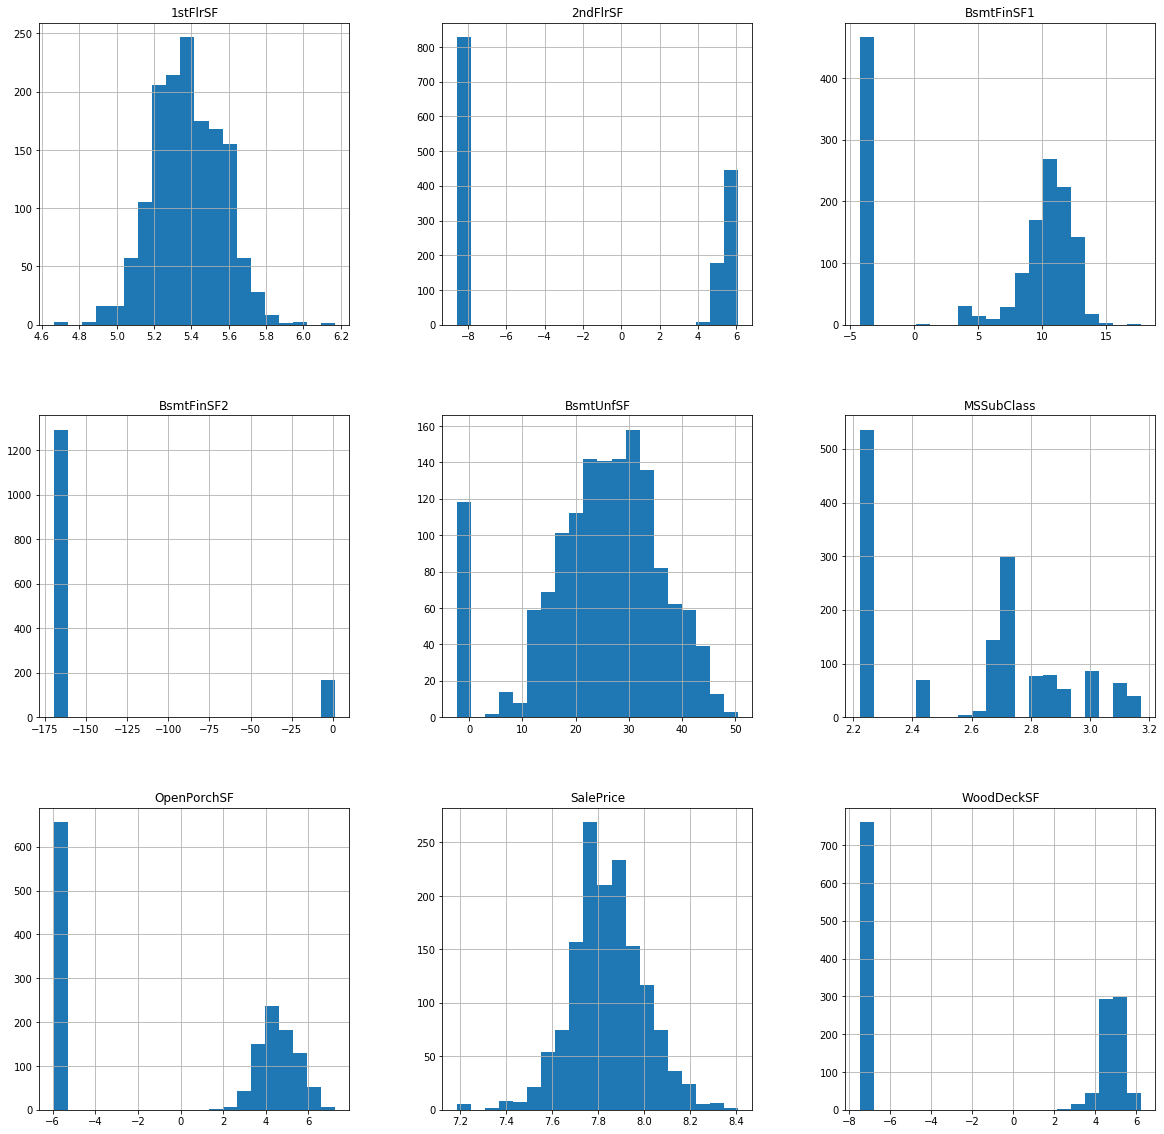

In [48]:
train_clean_num_norm[norm_ls].hist(bins = 20, figsize = (20,20))

### Data outliers


In [49]:
#a quick a dirty way to make sure we are not dealing with outliers

def replace_outliers (raw_df, cols):
    df = raw_df.copy()
    for col in cols:
        bounds = np.percentile(df[col], (0.1,99.9))
        low_bound = bounds[0]
        up_bound = bounds[1]
        df[col] = df[col].apply(lambda x: low_bound if x < low_bound else (up_bound if x > up_bound else x))
    
    return df

In [50]:
df_no_outliers = replace_outliers (train_clean_num_norm, norm_ls)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001744F0E5C48>,
      dtype=object)

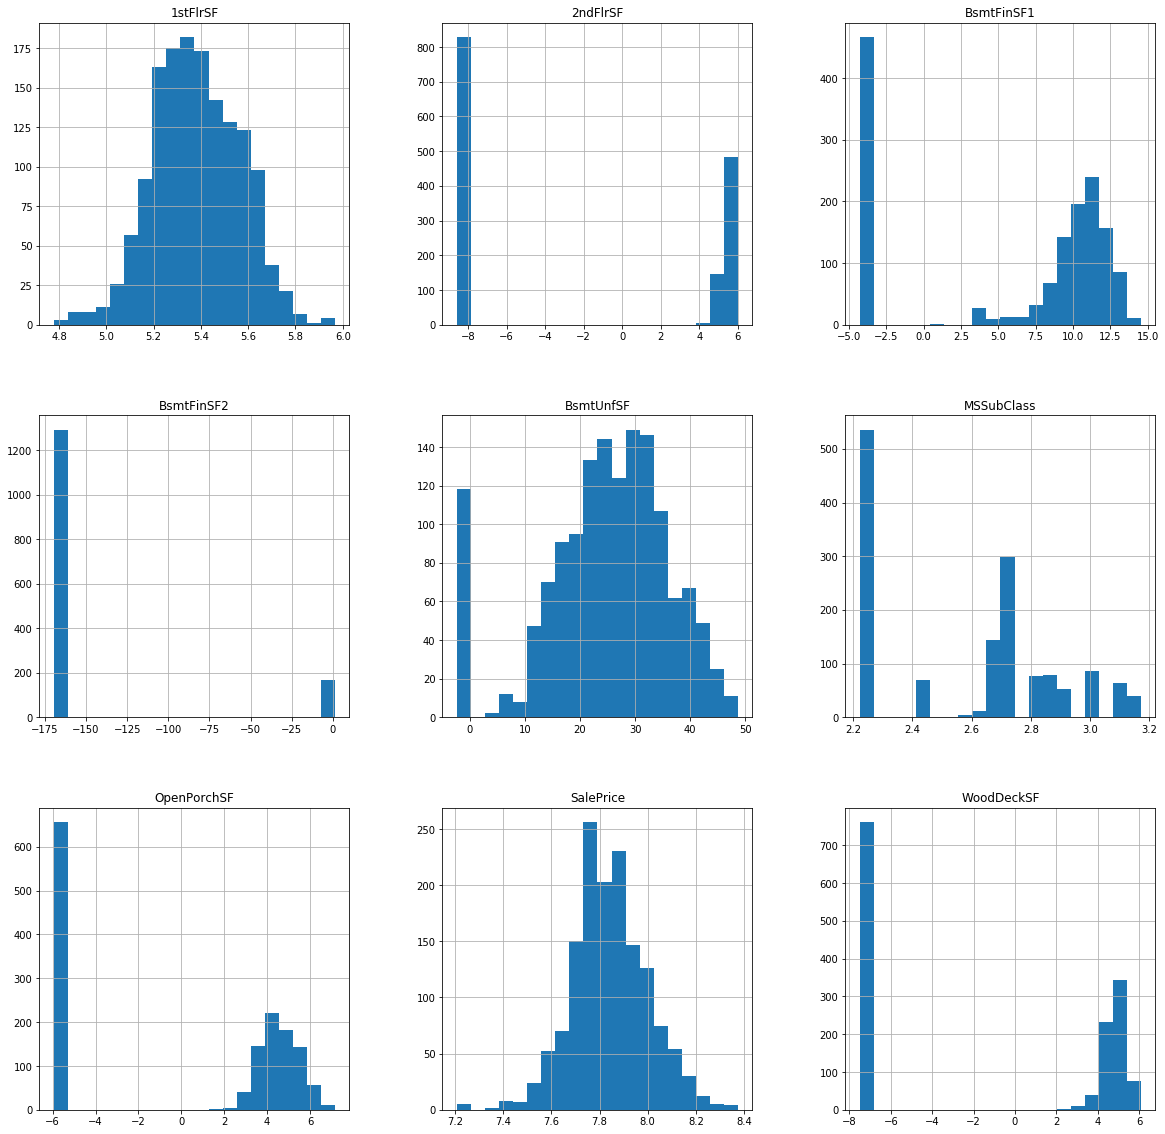

In [51]:
df_no_outliers[norm_ls].hist(bins = 20, figsize = (20,20))

## Function building
now we are going to combine our finding and approaches into functions

In [52]:
def data_clean (raw_df):
    df = raw_df.copy()
    cols_to_drop = drop_null_col(df, 40)
    df = df.drop(cols_to_drop, axis = 1)
    df = clear_na(df)
    return df 

In [53]:
#creating combined dataframe for process

train_raw_lable = train_raw.copy()
train_raw_lable['IsTrain'] = 1
y_train = train_raw_lable.SalePrice.copy()
train_raw_lable = train_raw_lable.drop('SalePrice', axis = 1)

test_raw_lable = test_raw.copy()
test_raw_lable['IsTrain'] = 0
all_data_raw = pd.concat([train_raw_lable, test_raw_lable], ignore_index=True, sort=False)


In [54]:
all_data_raw

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,IsTrain
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,0
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,0
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,0
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,0


In [55]:
all_clean = data_clean (all_data_raw)

In [56]:
all_clean.loc[all_clean.IsTrain == 1]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,IsTrain
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,1.0
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,1.0
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,1.0
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,1.0
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,1.0
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,1.0
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,1.0
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,366.0,0.0,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,1.0


In [57]:
all_clean.isnull().sum()

MSZoning       0
Street         0
LotShape       0
LandContour    0
Utilities      0
              ..
PoolArea       0
MiscVal        0
MoSold         0
YrSold         0
IsTrain        0
Length: 76, dtype: int64

In [58]:
X_all_txt, X_all_num = txt_num_split(all_clean)

In [59]:
import category_encoders as ce

def ce_encoding (fit_df, trans_df, cols):
    df = trans_df.copy()
    
    target_enc = ce.CatBoostEncoder(cols=cols)
    target_enc_fitted = target_enc.fit(fit_df[cols], y_train)
    tran_cols = target_enc_fitted.transform(df[cols])
    return tran_cols

In [60]:
def txt_col_preprocess (raw_df):
    
    df = raw_df.copy()
    
    #aggregate scattered values in Exterior2nd 
    combine_ls_e2 = ['CBlock', 'Other', 'Stone', 'AsphShn', 'ImStucc', 'Brk Cmn']
    df.Exterior2nd = df.Exterior2nd.apply(lambda x: 'Other' if x in combine_ls_e2 else x)
    
    #aggregate scattered values in Exterior1st 
    combine_ls_e1 = ['CBlock', 'Other', 'Stone', 'AsphShn', 'ImStucc', 'BrkComm']
    df.Exterior1st = df.Exterior1st.apply(lambda x: 'Other' if x in combine_ls_e1 else x)
    
    #encode cols with more than 10 unique values with category_encoders
    top_uni_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd']
    ce_fit = all_clean.loc[all_clean.IsTrain == 1].copy()
    ce_cols = ce_encoding(ce_fit, df, top_uni_cols)
    ce_cols = scaler(ce_cols, top_uni_cols)
    df = df.drop(top_uni_cols, axis = 1).join(ce_cols)
    
    #onehot encode the rest
    rest_txt_cols = df.columns.drop(top_uni_cols)
    col_for_oh = one_hot(df, rest_txt_cols)
    df = df.drop(rest_txt_cols, axis = 1).join(col_for_oh)
    

    
    return df
    
    
    

In [61]:
def num_col_preprocess (raw_df):
    
    df = raw_df.copy()
    
    norm_ls = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'MSSubClass', 'OpenPorchSF', 'WoodDeckSF']
    num_toscale = ['LotFrontage', 'LotArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'WoodDeckSF',
       'OpenPorchSF', 'PoolArea']
    num_cat_cols = ['GarageYrBlt', 'MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']
    
    #create new features
    df['HasPorach'] = (df['OpenPorchSF'] + df['EnclosedPorch'])>0
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['HasPool'] = df['PoolArea'] > 0
    new_cols = ['HasPorach', 'HasPool']
    oh_new_cols = one_hot(df, new_cols)
    df = df.drop(new_cols, axis = 1).join(oh_new_cols)
    
    #normalize and onehot other cols
    df = replace_outliers (df, norm_ls)
    df = norm_trans (norm_ls, df)
    oh_trnfm_cols = one_hot(df, num_cat_cols)
    df = df.drop(num_cat_cols, axis = 1).join(oh_trnfm_cols)
    
    #scale cols
    scale_cols = scaler(df, num_toscale)
    df = df.drop(num_toscale, axis = 1).join(scale_cols)
    

    
    
    return df
    

In [62]:
X_all_txt_processed = txt_col_preprocess (X_all_txt)

In [63]:
X_all_txt_processed

,Neighborhood,Exterior1st,Exterior2nd,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.416807,0.856628,0.866823,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.574190,0.322354,0.291883,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.416807,0.856628,0.866823,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.469999,0.325913,0.397944,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.856628,0.866823,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0.003929,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2915,0.003929,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2916,0.237665,0.856628,0.866823,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2917,0.237665,0.435641,0.397944,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
X_all_num_processed = num_col_preprocess(X_all_num)

In [65]:
X_all_num_processed

,Id,MSSubClass,OverallQual,OverallCond,MasVnrArea,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF,PoolArea
0,1.0,2.743724,7.0,5.0,196.0,1710.0,1.0,0.0,2.0,1.0,...,0.818236,0.0,0.354898,0.140098,0.347265,0.967024,0.0,0.000000,0.789966,0.0
1,2.0,2.221804,6.0,8.0,0.0,1262.0,0.0,1.0,2.0,0.0,...,0.865908,0.0,0.455789,0.206547,0.539277,0.000000,0.0,0.942108,0.000000,0.0
2,3.0,2.743724,7.0,5.0,162.0,1786.0,1.0,0.0,2.0,1.0,...,0.766435,0.0,0.538063,0.150573,0.383133,0.967639,0.0,0.000000,0.755731,0.0
3,4.0,2.807768,7.0,5.0,0.0,1717.0,1.0,0.0,1.0,0.0,...,0.663561,0.0,0.586057,0.123732,0.404777,0.961628,0.0,0.000000,0.739230,0.0
4,5.0,2.743724,8.0,5.0,350.0,2198.0,1.0,0.0,2.0,1.0,...,0.807597,0.0,0.564213,0.187398,0.491403,0.976197,0.0,0.913907,0.819814,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.0,3.117907,4.0,7.0,0.0,1092.0,0.0,0.0,1.0,1.0,...,0.000000,0.0,0.588594,0.089362,0.121477,0.947013,0.0,0.000000,0.000000,0.0
2915,2916.0,3.117907,4.0,5.0,0.0,1092.0,0.0,0.0,1.0,1.0,...,0.682154,0.0,0.462007,0.089362,0.121477,0.947013,0.0,0.000000,0.705544,0.0
2916,2917.0,2.221804,5.0,7.0,0.0,1224.0,1.0,0.0,1.0,0.0,...,0.900128,0.0,0.000000,0.200327,0.524251,0.000000,0.0,0.971554,0.000000,0.0
2917,2918.0,2.885531,5.0,5.0,0.0,970.0,0.0,1.0,1.0,0.0,...,0.718418,0.0,0.600621,0.149264,0.409400,0.000000,0.0,0.856834,0.731173,0.0


In [66]:
#lastly, we will normalize SalePrice separately
norm_ls = stats.boxcox(y_train.array+0.001)

In [67]:
y_train_norm, norm_p = norm_ls[0], norm_ls[1]

In [68]:
y_train_norm

array([7.93260818, 7.87826109, 7.95961575, ..., 8.02737948, 7.78100362,
       7.79588483])

In [69]:
X_all_processed = X_all_txt_processed.join(X_all_num_processed)

In [70]:
X = X_all_processed.loc[X_all_processed['IsTrain']==1]

In [71]:
X = X.drop('IsTrain', axis = 1)

In [72]:
X_test = X_all_processed.loc[X_all_processed['IsTrain']==0]

In [73]:
X_test = X_test.drop('IsTrain', axis = 1)

# Modeling
this is borrowed from https://www.kaggle.com/datafan07/top-1-approach-eda-new-models-and-stacking

In [80]:
# Loading neccesary packages for modelling.

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor # This is for stacking part, works well with sklearn and others...

In [81]:
# Setting kfold for future use.

kf = KFold(10, random_state=42)

In [84]:
# Some parameters for ridge, lasso and elasticnet.

alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge_cv

ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

# lasso_cv:

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

# elasticnet_cv:

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=1e7,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio))

# svr:

svr = make_pipeline(RobustScaler(),
                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))

# gradientboosting:

gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

# lightgbm:

lightgbm = LGBMRegressor(objective='regression',
                         n_estimators=3500,
                         num_leaves=5,
                         learning_rate=0.00721,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         n_jobs=-1,
                         bagging_seed=42,
                         feature_fraction_seed=42,
                         bagging_freq=7,
                         feature_fraction=0.1294,
                         min_data_in_leaf=8)


# hist gradient boosting regressor:

hgrd= HistGradientBoostingRegressor(    loss= 'least_squares',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225,
                                    random_state=42)


#to replace xgboost for meta_regressor
rf = RandomForestRegressor()


# stacking regressor:

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                         lightgbm,hgrd),
                                meta_regressor=rf,
                                use_features_in_secondary=True)

In [85]:
def model_check(X, y, estimators, cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [87]:
# Setting list of estimators and labels for them:

estimators = [ridge, lasso, elasticnet, gbr, rf, lightgbm, svr, hgrd]
labels = [
    'Ridge', 'Lasso', 'Elasticnet', 'GradientBoostingRegressor',
    'RandomForestRegressor', 'LGBMRegressor', 'SVR', 'HistGradientBoostingRegressor',
]

In [88]:
# Executing cross validation.

raw_models = model_check(X, y_train_norm, estimators, kf)
raw_models

,Model Name,Train RMSE,Test RMSE,Test Std,Time
3,GradientBoostingRegressor,0.032045,0.047582,0.007921,10.556284
7,HistGradientBoostingRegressor,0.037304,0.049664,0.006679,2.467605
2,Elasticnet,0.046132,0.052103,0.010860,6.190654
1,Lasso,0.046014,0.052105,0.010881,2.018405
0,Ridge,0.042396,0.052462,0.010709,5.803588
4,RandomForestRegressor,0.021242,0.056113,0.007067,5.529520
6,SVR,0.037272,0.063480,0.010863,2.033265
5,LGBMRegressor,NaN,NaN,NaN,0.075099


In [95]:
from datetime import datetime
# Fitting the models on train data.

print('=' * 20, 'START Fitting', '=' * 20)
print('=' * 55)

print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(X.values, y_train_norm)
print(datetime.now(), 'Elasticnet')
elastic_model_full_data = elasticnet.fit(X, y_train_norm)
print(datetime.now(), 'Lasso')
lasso_model_full_data = lasso.fit(X, y_train_norm)
print(datetime.now(), 'Ridge')
ridge_model_full_data = ridge.fit(X, y_train_norm)
print(datetime.now(), 'SVR')
svr_model_full_data = svr.fit(X, y_train_norm)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y_train_norm)
print(datetime.now(), 'Hist')
hist_full_data = hgrd.fit(X, y_train_norm)

print('=' * 20, 'FINISHED Fitting', '=' * 20)
print('=' * 58)

==================== START Fitting ====================
2020-10-01 22:01:42.761130 StackingCVRegressor
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is se

In [93]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) +
            (0.1 * lasso_model_full_data.predict(X)) +
            (0.1 * ridge_model_full_data.predict(X)) +
            (0.1 * svr_model_full_data.predict(X)) +
            (0.15 * gbr_model_full_data.predict(X)) +
            (0.1 * hist_full_data.predict(X)) +
            (0.35 * stack_gen_model.predict(X.values)))

In [96]:
y_sub_blend_raw = blend_models_predict(X_test)

In [97]:
y_sub_blend_raw

array([7.72062032, 7.80510687, 7.87750204, ..., 7.8309155 , 7.71317143,
       7.93067559])

In [98]:
from scipy.special import inv_boxcox
y_sub_blend = inv_boxcox(y_sub_blend_raw, norm_p)

In [99]:
y_sub_blend

array([122383.44179431, 150940.5246391 , 181150.67305147, ...,
       161036.81161636, 120160.63505555, 207469.01047143])

In [100]:
y_sub_gbr_raw = gbr_model_full_data.predict(X_test)

In [101]:
y_sub_gbr = inv_boxcox(y_sub_gbr_raw, norm_p)

In [113]:
sub_blend = pd.DataFrame({'ID': sample_raw['Id'], 'SalePrice': y_sub_blend})

In [115]:
sub_blend.to_csv('submissions/sub_blend.csv', index = False)

In [105]:
sub_blend

,ID,SalePrice
0,1460,122383.441794
1,1461,150940.524639
2,1462,181150.673051
3,1463,195645.162633
4,1464,199550.438257
...,...,...
1454,2914,84941.543883
1455,2915,84530.626297
1456,2916,161036.811616
1457,2917,120160.635056


In [116]:
sub_gbr = pd.DataFrame({'ID': sample_raw['Id'], 'SalePrice': y_sub_gbr})

In [117]:
sub_gbr.to_csv('submissions/sub_gbr.csv', index = False)

In [102]:
sample_raw

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [112]:
X_test['ID']

KeyError: 'ID'